In [1]:
import os
import cv2
import numpy as np
from PIL import Image

import util

# Load image

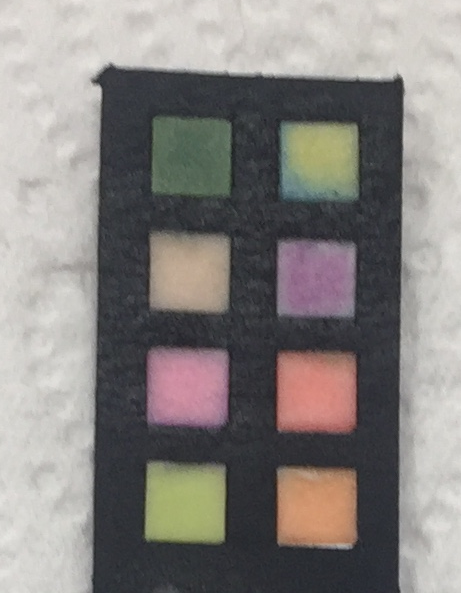

In [2]:
img_path = 'images/image.png'

image = Image.open(img_path).convert('RGB')
image = util.image_transpose_exif(image)
image

# Convert Pillow Image to numpy array

In [3]:
img = np.array(image)

# Resize image 

In [4]:
WORKING_WIDTH = 350
resize_ratio = WORKING_WIDTH / img.shape[1]
img_resized = cv2.resize(img, None, fx=resize_ratio, fy=resize_ratio)

# convert to grayscale

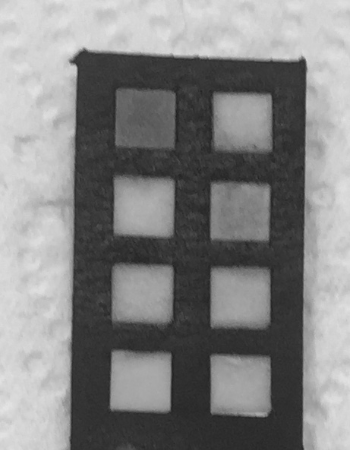

In [5]:
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
Image.fromarray(img_gray)

# Smooth the image

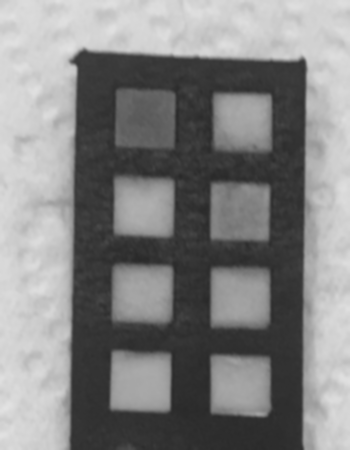

In [6]:
img_smooth = cv2.GaussianBlur(img_gray, (5, 5), 0)
Image.fromarray(img_smooth)

# Add a black border

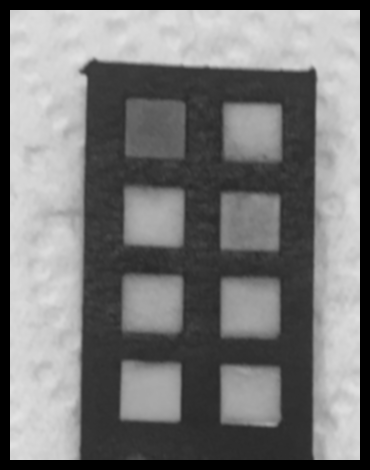

In [7]:
BORDER_SIZE = 10
img_smooth_b = cv2.copyMakeBorder(img_smooth, 
                                  top=BORDER_SIZE, 
                                  bottom=BORDER_SIZE, 
                                  left=BORDER_SIZE, 
                                  right=BORDER_SIZE, 
                                  borderType=cv2.BORDER_CONSTANT, 
                                  value=0)
Image.fromarray(img_smooth_b)

# Apply denoising and adaptive thresholding

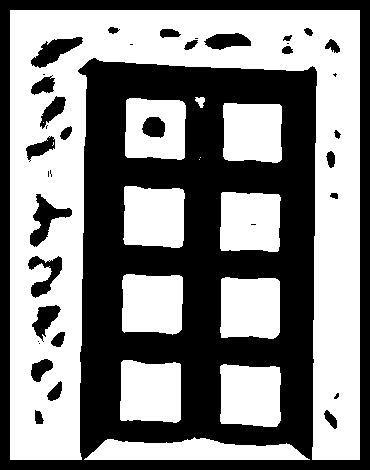

In [8]:
SQUARE_BOX_BLOCK_SIZE_RATIO = 0.2
block_size = int(WORKING_WIDTH * SQUARE_BOX_BLOCK_SIZE_RATIO)
block_size = block_size - block_size % 2 + 1

img_den = cv2.fastNlMeansDenoising(img_smooth_b, None, h=7)
img_thr = cv2.adaptiveThreshold(img_den, 
                                255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 
                                block_size, 0)
Image.fromarray(img_thr)

# Erode and dilate

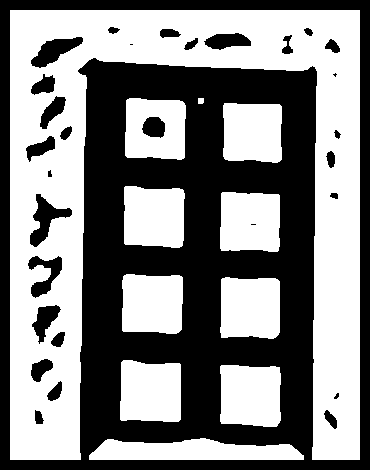

In [9]:
kernel_size = np.ones([5, 5], np.uint8)
img_e = cv2.erode(img_thr, kernel_size, iterations=1)
img_d = cv2.dilate(img_e, kernel_size, iterations=1)
Image.fromarray(img_d)

# Find contours

In [10]:
contours, _ = cv2.findContours(img_d.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

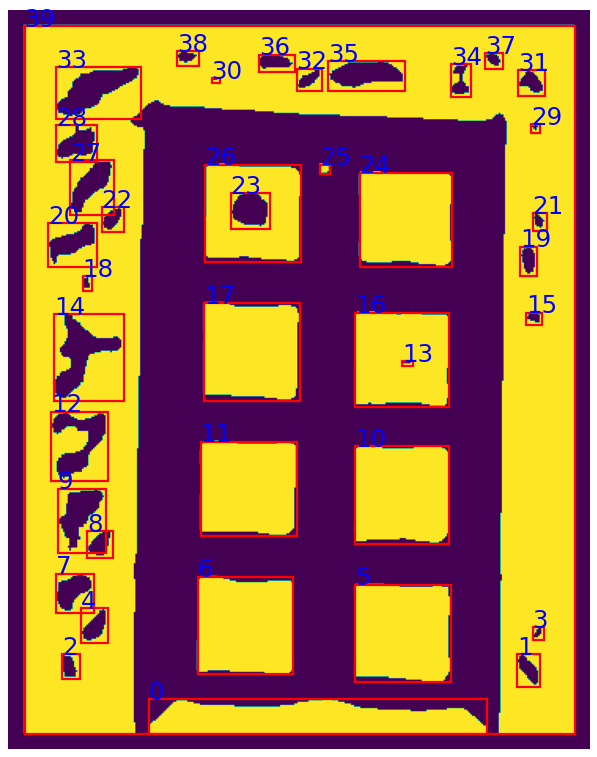

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12), dpi=80)
for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    rect = plt.Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    plt.text(x, y, i, fontsize=22, color='blue')
    plt.gca().add_patch(rect)
    
plt.axis('off')
plt.imshow(img_d)
plt.show()

# Filter contours based on area and ractangle ratio

In [12]:
BOX_MIN_WIDTH_RATIO = 0.1
BOX_MAX_WIDTH_RATIO = 0.2
RECT_RATIO = 0.8

img_width, img_height = img.shape[1], img.shape[0]
min_area = pow(img_width * BOX_MIN_WIDTH_RATIO, 2)
max_area = pow(img_width * BOX_MAX_WIDTH_RATIO, 2)

candi_contours = []
for cnt in contours:
    # Just keep rectangle contours
    cnt_points = cv2.approxPolyDP(cnt, 0.09 * cv2.arcLength(cnt, True), True)
    if len(cnt_points) != 4:
        continue
        
    # Filter based on area
    area = cv2.contourArea(cnt)
    if not (min_area < area < max_area):
        continue
        
    # level cnt, so that squares are detected better in tilted images
    rotated_rect = util.crop_level_with_rectangle(img_d, cv2.minAreaRect(cnt))
    # Filter based on rectangle ratio
    width, height = rotated_rect.shape
    rect_ratio = min(width, height) / max(width, height)
    if rect_ratio < RECT_RATIO:
        continue

    candi_contours.append(cnt)

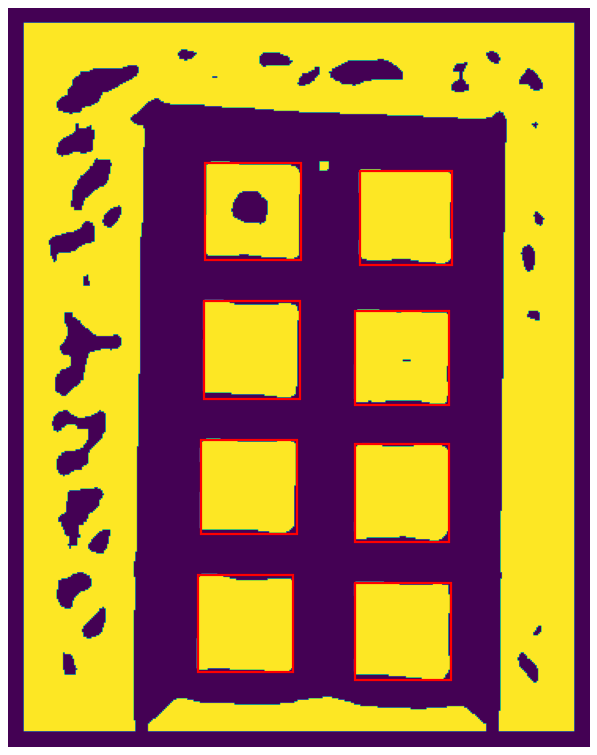

In [13]:
plt.figure(figsize=(16, 12), dpi=80)
for cnt in candi_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    rect = plt.Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    plt.gca().add_patch(rect)
    
plt.axis('off')
plt.imshow(img_d)
plt.show()

# Drop those contours that have area far beyond mean area

In [14]:
AVG_AREA_THRESH = 0.5

avg_area = np.mean(
    [cv2.contourArea(cv2.approxPolyDP(cnt, 0.09 * cv2.arcLength(cnt, True), True)) for cnt in candi_contours]
)
filtered_contours = []
for cnt in candi_contours:
    cnt_area = cv2.contourArea(cv2.approxPolyDP(cnt, 0.09 * cv2.arcLength(cnt, True), True))
    if (avg_area * AVG_AREA_THRESH) < cnt_area < (avg_area * (2 - AVG_AREA_THRESH)):
        filtered_contours.append(cnt)

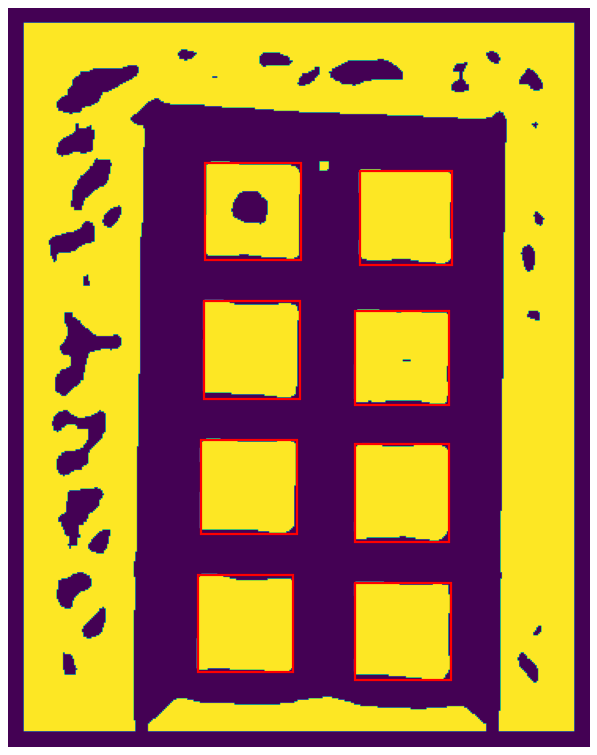

In [15]:
plt.figure(figsize=(16, 12), dpi=80)
for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    rect = plt.Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    plt.gca().add_patch(rect)
    
plt.axis('off')
plt.imshow(img_d)
plt.show()

# Scale coordinates of img_d to coordinates of img

In [16]:
rects = []
for cnt in filtered_contours:
    cnt_scaled = np.array(((cnt - BORDER_SIZE) / resize_ratio).round(), dtype=np.int32)
    x, y, w, h = cv2.boundingRect(cnt_scaled)
    rects.append([x, y, w, h])

# Crop segmented boxes and save them

In [17]:
FIXED_BOX_SIZE = (64, 64)

for i, re in enumerate(rects):
    x, y, w, h = re
    
    # crop box
    img_box = img[y:y + h, x:x + w].copy()
    
    # Resize to a fixed size
    img_box = cv2.resize(img_box, FIXED_BOX_SIZE, interpolation=cv2.INTER_AREA)
    
    # save box
    Image.fromarray(img_box).save(os.path.join('images', f'box_{i}.png'))